In [67]:

# Decoding fix: top-k sampling with temperature and correct end token id
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Ensure tokenizer is already fit
assert 'tokenizer' in globals(), "Tokenizer not found; run the training cells first."
end_id = tokenizer.word_index.get('endseq')
start_id = tokenizer.word_index.get('startseq')
assert end_id is not None and start_id is not None, "startseq/endseq not in tokenizer vocabulary."

# Ensure encoder/decoder models exist
assert 'encoder_model' in globals() and 'decoder_model' in globals() and 'cheXnet_Features' in globals(), "Models/features missing."


def _top_k_logits(probs: np.ndarray, k: int) -> np.ndarray:
    if k <= 0 or k >= probs.size:
        return probs
    # zero-out everything except top-k
    idx = np.argpartition(probs, -k)[-k:]
    masked = np.zeros_like(probs)
    masked[idx] = probs[idx]
    return masked


def _sample_from_probs(probs: np.ndarray, temperature: float = 1.0, top_k: int = 0) -> int:
    p = probs.astype('float64')
    p = np.maximum(p, 1e-9)
    if temperature and temperature != 1.0:
        p = np.power(p, 1.0 / temperature)
    if top_k and top_k > 0:
        p = _top_k_logits(p, top_k)
    p = p / p.sum()
    return int(np.random.choice(len(p), p=p))


def generate_report(img_id: str, max_len: int = 153, top_k: int = 5, temperature: float = 0.8) -> str:
    image = cheXnet_Features[img_id]
    image_features = encoder_model.predict(image)
    
    input_tokens = [start_id]
    words = []
    for _ in range(max_len):
        inp = pad_sequences([input_tokens], max_len, padding='post')
        preds = decoder_model.predict([inp, image_features])
        next_id = _sample_from_probs(preds[0], temperature=temperature, top_k=top_k)
        if next_id == end_id or next_id == 0 or next_id not in tokenizer.index_word:
            break
        next_word = tokenizer.index_word[next_id]
        words.append(next_word)
        input_tokens.append(next_id)
    return ' '.join(words)

# Backward-compatible alias
def greedysearch(img_id: str) -> str:
    return generate_report(img_id, top_k=1, temperature=1.0)



In [17]:
import tensorflow as tf
from tensorflow.keras.applications import densenet
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import cv2
import tensorflow as tf
import re
import pickle
from PIL import Image
from skimage.transform import resize
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Embedding, Conv2D, Concatenate, Flatten, Add, Dropout, GRU
import random
import datetime
from nltk.translate.bleu_score import sentence_bleu

In [5]:
train_data = pd.read_csv('Final_Train_Data.csv')
test_data = pd.read_csv('Final_Test_Data.csv')
cv_data = pd.read_csv('Final_CV_Data.csv')

In [6]:
print('train data shape : ',train_data.shape)
train_data.head(2)

train data shape :  (2760, 4)


,Person_id,Image1,Image2,Report
0,NLMCXR_png/CXR992_IM-2477-0001_0,NLMCXR_png/CXR992_IM-2477-0001-0001.png,NLMCXR_png/CXR992_IM-2477-0001-0002.png,startseq there are bilateral pulmonary nodules...
1,NLMCXR_png/CXR2863_IM-1271_0,NLMCXR_png/CXR2863_IM-1271-2001.png,NLMCXR_png/CXR2863_IM-1271-3001.png,startseq the lungs are clear bilaterally . sp...


In [7]:
print('test data shape : ',test_data.shape)
test_data.head(2)

test data shape :  (396, 4)


,Person_id,Image1,Image2,Report
0,NLMCXR_png/CXR3464_IM-1683_0,NLMCXR_png/CXR3464_IM-1683-1001.png,NLMCXR_png/CXR3464_IM-1683-2001.png,startseq the heart and lungs have the interval...
1,NLMCXR_png/CXR841_IM-2365_0,NLMCXR_png/CXR841_IM-2365-1001.png,NLMCXR_png/CXR841_IM-2365-2001.png,startseq the heart normal size . the mediasti...


In [8]:
print('CV data shape : ',cv_data.shape)
cv_data.head(2)

CV data shape :  (551, 4)


,Person_id,Image1,Image2,Report
0,NLMCXR_png/CXR44_IM-2078,NLMCXR_png/CXR44_IM-2078-1001.png,NLMCXR_png/CXR44_IM-2078-1001.png,startseq the heart pulmonary and mediastinum a...
1,NLMCXR_png/CXR2201_IM-0811,NLMCXR_png/CXR2201_IM-0811-1002.png,NLMCXR_png/CXR2201_IM-0811-1002.png,startseq bilateral calcified granulomas stable...


In [9]:
chexNet = densenet.DenseNet121(include_top=False, weights = None,   input_shape=(224,224,3), pooling="avg")
X = chexNet.output
X = Dense(14, activation="sigmoid", name="predictions")(X)
model = Model(inputs=chexNet.input, outputs=X)

In [68]:
#loadind pretrained weights for ChexNet model
model.load_weights('brucechou1983_CheXNet_Keras_0.3.0_weights.h5')

In [69]:
chexNet = Model(inputs = model.input, outputs = model.layers[-2].output)

In [12]:
chexNet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 56, 56, 64)        │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 56, 56, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 56, 56, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [18]:
tf.keras.utils.plot_model(chexNet,show_shapes=True, dpi = 42)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [19]:
def load_image(img_name):
    image = Image.open(img_name)
    X = np.asarray(image.convert("RGB"))
    X = np.asarray(X)
    X = preprocess_input(X)
    X = resize(X, (224,224,3))
    X = np.expand_dims(X, axis=0)
    X = np.asarray(X)
    return X

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5951809..2.2147396].


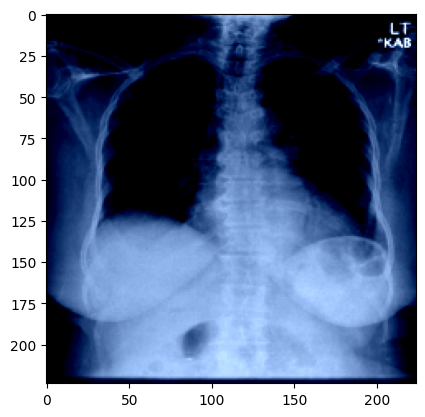

In [20]:
img = load_image('NLMCXR_png/CXR1082_IM-0058-1001.png')
plt.imshow(img[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4425004].


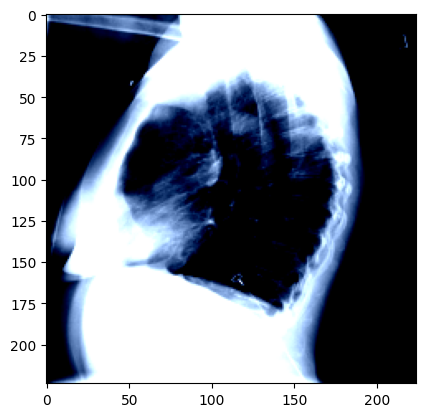

In [21]:
img = load_image('NLMCXR_png/CXR2828_IM-1247-2001.png')
plt.imshow(img[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0837548..2.248886].


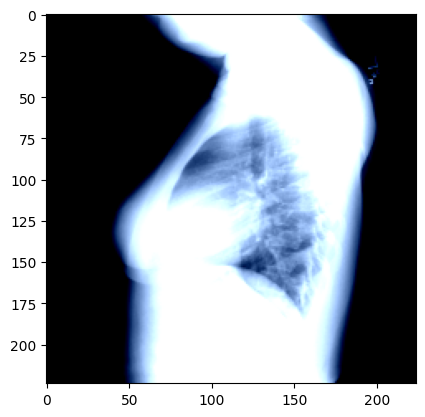

In [22]:
img = load_image('NLMCXR_png/CXR1_1_IM-0001-3001.png')
plt.imshow(img[0])

In [ ]:
Xnet_features = {}
for key, img1, img2, finding in tqdm(train_data.values):
    i1 = load_image(img1)
    img1_features = chexNet.predict(i1)
    i2 = load_image(img2)
    img2_features = chexNet.predict(i2)
    input_ = np.concatenate((img1_features, img2_features), axis=1)
    Xnet_features[key] = input_

for key, img1, img2, finding in tqdm(test_data.values):
    i1 = load_image(img1)
    img1_features = chexNet.predict(i1)
    i2 = load_image(img2)
    img2_features = chexNet.predict(i2)
    input_ = np.concatenate((img1_features, img2_features), axis=1)
    Xnet_features[key] = input_

for key, img1, img2, finding in tqdm(cv_data.values):
    i1 = load_image(img1)
    img1_features = chexNet.predict(i1)
    i2 = load_image(img2)
    img2_features = chexNet.predict(i2)
    input_ = np.concatenate((img1_features, img2_features), axis=1)
    Xnet_features[key] = input_

  0%|          | 0/2760 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [24]:
Xnet_features['NLMCXR_png/CXR236_IM-0924_0'].shape

(1, 2048)

In [25]:
# save the file for future use
f = open('Image_features_ecoder_decoder.pickle','wb')
pickle.dump(Xnet_features, f)
f.close()

In [26]:
len(Xnet_features)

3707

In [27]:
X_train = train_data['Person_id']
X_test = test_data['Person_id']
X_cv = cv_data['Person_id']
y_train = train_data['Report']
y_test =  test_data['Report']
y_cv =  cv_data['Report']

In [28]:
cheXnet_Features = Xnet_features

In [29]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(y_train.values)

In [30]:
pading_size = 153   # Max length

In [31]:
vocab_size = len(tokenizer.word_index.keys()) + 1

In [35]:
f = open('glove_vectors','rb') # 300d glove vectors
glove_vectors = pickle.load(f)
f.close()

In [36]:
embedding_matrix = np.zeros((vocab_size,300))
for word, i in tokenizer.word_index.items():
    if word in glove_vectors.keys():
        vec = glove_vectors[word]
        embedding_matrix[i] = vec
    else:
        continue

In [37]:
BATCH_SIZE = 12

In [38]:
def load_image(id_, report):
    '''Loads the Image Features with their corresponding Ids'''
    img_feature = cheXnet_Features[id_.decode('utf-8')][0]
    return img_feature, report

In [39]:
def dataset_generator(img_name, caption):

    dataset = tf.data.Dataset.from_tensor_slices((img_name, caption))

  # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(load_image, [item1, item2], [tf.float32, tf.string]),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

  # Shuffle and batch
    dataset = dataset.shuffle(500).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [40]:
train_generator = dataset_generator(X_train, y_train)
cv_generator = dataset_generator(X_cv, y_cv)

In [41]:
def bytes_to_string(arr):
    '''The generator gives provides data in bytes. This function converts them back to strings for manipulation'''
    for i in range(len(arr)):
        arr[i] = arr[i].decode('utf-8')
    return arr

In [42]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import tensorflow as tf

def convert(images, reports, tokenizer, vocab_size, maxlen=153):
    '''
    Converts a batch of data (images, reports) into model-ready input/output arrays.
    - images: list/array of image tensors
    - reports: list of text reports
    - tokenizer: fitted tokenizer for text-to-index conversion
    - vocab_size: size of vocabulary for one-hot encoding
    - maxlen: max sequence length for padding
    '''
    imgs = []
    in_reports = []
    out_reports = []

    for i in range(len(images)):
        # Convert report text → sequence of token IDs
        sequence = [tokenizer.word_index[e] for e in reports[i].split() if e in tokenizer.word_index.keys()]

        # Create multiple training pairs from one report
        for j in range(1, len(sequence)):
            in_seq = sequence[:j]
            out_seq = sequence[j]

            out_seq = tf.keras.utils.to_categorical(out_seq, num_classes=vocab_size)

            imgs.append(images[i])
            in_reports.append(in_seq)
            out_reports.append(out_seq)

    # ✅ Pad all input sequences to same length
    in_reports = pad_sequences(in_reports, maxlen=maxlen, padding='post')

    # ✅ Convert lists to NumPy arrays for model input
    imgs = np.array(imgs)
    out_reports = np.array(out_reports)

    return imgs, in_reports, out_reports


In [43]:
input1 = Input(shape=(2048,), name='Image_input')
dense1 = Dense(256, kernel_initializer=tf.keras.initializers.glorot_uniform(seed = 56), name='dense_encoder')(input1)

input2 = Input(shape=(153,), name='Text_Input')
embedding_layer = Embedding(input_dim = vocab_size, output_dim = 300, input_length=153, mask_zero=True, trainable=False,
                weights=[embedding_matrix], name="Embedding_layer")
emb = embedding_layer(input2)

LSTM1 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), return_sequences=True, name="LSTM1")(emb)
#LSTM1_output = LSTM1(emb)

LSTM2 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), name="LSTM2")
LSTM2_output = LSTM2(LSTM1)

dropout1 = Dropout(0.5, name='dropout1')(LSTM2_output)

dec =  tf.keras.layers.Add()([dense1, dropout1])

fc1 = Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed = 63), name='fc1')
fc1_output = fc1(dec)
dropout2 = Dropout(0.4, name='dropout2')(fc1_output)
output_layer = Dense(vocab_size, activation='softmax', name='Output_layer')
output = output_layer(dropout2)

encoder_decoder = Model(inputs = [input1, input2], outputs = output)
encoder_decoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Text_Input (InputLayer)       │ (None, 153)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Embedding_layer (Embedding)   │ (None, 153, 300)          │         435,000 │ Text_Input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal (NotEqual)          │ (None, 153)               │               0 │ Text_Input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ LSTM1 (LSTM)                  │ (None, 153, 256)          │         570,368 │ Embedding_layer[0][0],     │
│                               │                           │                 │ not_equal[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Image_input (InputLayer)      │ (None, 2048)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ LSTM2 (LSTM)                  │ (None, 256)               │         525,312 │ LSTM1[0][0],               │
│                               │                           │                 │ not_equal[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_encoder (Dense)         │ (None, 256)               │         524,544 │ Image_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout1 (Dropout)            │ (None, 256)               │               0 │ LSTM2[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 256)               │               0 │ dense_encoder[0][0],       │
│                               │                           │                 │ dropout1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ fc1 (Dense)                   │ (None, 256)               │          65,792 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout2 (Dropout)            │ (None, 256)               │               0 │ fc1[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Output_layer (Dense)          │ (None, 1450)              │         372,650 │ dropout2[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,493,666 (9.51 MB)

 Trainable params: 2,058,666 (7.85 MB)

 Non-trainable params: 435,000 (1.66 MB)

In [44]:
tf.keras.utils.plot_model(encoder_decoder,show_shapes=True, dpi = 52)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [45]:
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction='sum_over_batch_size')

def maskedLoss(y_true, y_pred):
    #getting mask value
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))

    #calculating the loss
    loss_ = loss_function(y_true, y_pred)

    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)

    #applying the mask to loss
    loss_ = loss_*mask

    #getting mean over all the values
    loss_ = tf.reduce_mean(loss_)
    return loss_

In [46]:
optimizer = tf.keras.optimizers.Adam(0.001)
encoder_decoder.compile(optimizer, loss = maskedLoss)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'Tensorboard/logs_m1/fit3/' + current_time + '/train'
val_log_dir = 'Tensorboard/logs_m1/fit3/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
val_summary_writer = tf.summary.create_file_writer(val_log_dir)

In [48]:
from tqdm import tqdm  # for progress bar

# Training setup
epoch_train_loss = []
epoch_val_loss = []

EPOCHS = 20

for epoch in range(EPOCHS):
    print(f"\nEPOCH : {epoch+1}")
    start = time.time()
    batch_loss_tr = 0.0
    batch_loss_vl = 0.0

    # ---------------- TRAINING ----------------
    print("Training...")
    for img, report in tqdm(train_generator, total=len(X_train)//14):
        r1 = bytes_to_string(report.numpy())

        # Convert to inputs and outputs
        img_input, rep_input, output_word = convert(img.numpy(), r1, tokenizer, vocab_size)
        rep_input = pad_sequences(rep_input, maxlen=153, padding='post')

        # Train model on this batch
        results = encoder_decoder.train_on_batch([img_input, rep_input], output_word)

        # Handle both float and list outputs
        if isinstance(results, (list, tuple)):
            loss_value = results[0]
        else:
            loss_value = results

        batch_loss_tr += float(loss_value)

    train_loss = batch_loss_tr / (X_train.shape[0] // 14)

    # TensorBoard logging (optional)
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss, step=epoch)

    # ---------------- VALIDATION ----------------
    print("Validating...")
    for img, report in tqdm(cv_generator, total=len(X_cv)//14):
        r1 = bytes_to_string(report.numpy())

        img_input, rep_input, output_word = convert(img.numpy(), r1, tokenizer, vocab_size)
        rep_input = pad_sequences(rep_input, maxlen=153, padding='post')

        results = encoder_decoder.test_on_batch([img_input, rep_input], output_word)

        if isinstance(results, (list, tuple)):
            loss_value = results[0]
        else:
            loss_value = results

        batch_loss_vl += float(loss_value)

    val_loss = batch_loss_vl / (X_cv.shape[0] // 14)

    with val_summary_writer.as_default():
        tf.summary.scalar('loss', val_loss, step=epoch)

    epoch_train_loss.append(train_loss)
    epoch_val_loss.append(val_loss)

    print(f"Training Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")
    print(f"Time Taken: {time.time() - start:.2f} sec")

    # Save model weights for each epoch
    encoder_decoder.save_weights(f'encoder_decoder_epoch_{epoch+1}.weights.h5')

    print('-' * 80)



EPOCH : 1
Training...


230it [20:29,  5.35s/it]                                                                                                   


Validating...


46it [01:31,  1.98s/it]                                                                                                    


Training Loss: 0.0036 | Validation Loss: 0.0034
Time Taken: 1321.27 sec
--------------------------------------------------------------------------------

EPOCH : 2
Training...


230it [20:17,  5.29s/it]                                                                                                   


Validating...


46it [01:32,  2.02s/it]                                                                                                    


Training Loss: 0.0032 | Validation Loss: 0.0030
Time Taken: 1310.71 sec
--------------------------------------------------------------------------------

EPOCH : 3
Training...


230it [20:26,  5.33s/it]                                                                                                   


Validating...


46it [01:33,  2.03s/it]                                                                                                    


Training Loss: 0.0029 | Validation Loss: 0.0028
Time Taken: 1319.88 sec
--------------------------------------------------------------------------------

EPOCH : 4
Training...


230it [20:24,  5.33s/it]                                                                                                   


Validating...


46it [01:31,  2.00s/it]                                                                                                    


Training Loss: 0.0027 | Validation Loss: 0.0026
Time Taken: 1316.75 sec
--------------------------------------------------------------------------------

EPOCH : 5
Training...


230it [20:19,  5.30s/it]                                                                                                   


Validating...


46it [01:32,  2.02s/it]                                                                                                    


Training Loss: 0.0025 | Validation Loss: 0.0025
Time Taken: 1312.52 sec
--------------------------------------------------------------------------------

EPOCH : 6
Training...


230it [20:20,  5.30s/it]                                                                                                   


Validating...


46it [01:34,  2.07s/it]                                                                                                    


Training Loss: 0.0024 | Validation Loss: 0.0024
Time Taken: 1315.11 sec
--------------------------------------------------------------------------------

EPOCH : 7
Training...


230it [20:20,  5.31s/it]                                                                                                   


Validating...


46it [01:32,  2.01s/it]                                                                                                    


Training Loss: 0.0023 | Validation Loss: 0.0023
Time Taken: 1313.30 sec
--------------------------------------------------------------------------------

EPOCH : 8
Training...


230it [20:21,  5.31s/it]                                                                                                   


Validating...


46it [01:32,  2.01s/it]                                                                                                    


Training Loss: 0.0022 | Validation Loss: 0.0022
Time Taken: 1313.79 sec
--------------------------------------------------------------------------------

EPOCH : 9
Training...


230it [20:35,  5.37s/it]                                                                                                   


Validating...


46it [01:32,  2.01s/it]                                                                                                    


Training Loss: 0.0021 | Validation Loss: 0.0021
Time Taken: 1327.69 sec
--------------------------------------------------------------------------------

EPOCH : 10
Training...


230it [20:19,  5.30s/it]                                                                                                   


Validating...


46it [01:32,  2.01s/it]                                                                                                    


Training Loss: 0.0021 | Validation Loss: 0.0021
Time Taken: 1311.97 sec
--------------------------------------------------------------------------------

EPOCH : 11
Training...


230it [2:00:07, 31.34s/it]                                                                                                 


Validating...


46it [01:35,  2.07s/it]                                                                                                    


Training Loss: 0.0020 | Validation Loss: 0.0020
Time Taken: 7303.22 sec
--------------------------------------------------------------------------------

EPOCH : 12
Training...


230it [21:02,  5.49s/it]                                                                                                   


Validating...


46it [01:39,  2.17s/it]                                                                                                    


Training Loss: 0.0020 | Validation Loss: 0.0019
Time Taken: 1362.32 sec
--------------------------------------------------------------------------------

EPOCH : 13
Training...


230it [24:48,  6.47s/it]                                                                                                   


Validating...


46it [01:52,  2.46s/it]                                                                                                    


Training Loss: 0.0019 | Validation Loss: 0.0019
Time Taken: 1601.87 sec
--------------------------------------------------------------------------------

EPOCH : 14
Training...


230it [22:28,  5.86s/it]                                                                                                   


Validating...


46it [01:46,  2.31s/it]                                                                                                    


Training Loss: 0.0019 | Validation Loss: 0.0019
Time Taken: 1454.86 sec
--------------------------------------------------------------------------------

EPOCH : 15
Training...


230it [21:43,  5.67s/it]                                                                                                   


Validating...


46it [01:46,  2.31s/it]                                                                                                    


Training Loss: 0.0018 | Validation Loss: 0.0018
Time Taken: 1409.68 sec
--------------------------------------------------------------------------------

EPOCH : 16
Training...


230it [21:44,  5.67s/it]                                                                                                   


Validating...


46it [01:42,  2.23s/it]                                                                                                    


Training Loss: 0.0018 | Validation Loss: 0.0018
Time Taken: 1407.14 sec
--------------------------------------------------------------------------------

EPOCH : 17
Training...


230it [22:21,  5.83s/it]                                                                                                   


Validating...


46it [01:49,  2.39s/it]                                                                                                    


Training Loss: 0.0018 | Validation Loss: 0.0018
Time Taken: 1451.12 sec
--------------------------------------------------------------------------------

EPOCH : 18
Training...


230it [21:59,  5.74s/it]                                                                                                   


Validating...


46it [01:40,  2.19s/it]                                                                                                    


Training Loss: 0.0017 | Validation Loss: 0.0017
Time Taken: 1420.38 sec
--------------------------------------------------------------------------------

EPOCH : 19
Training...


230it [22:15,  5.81s/it]                                                                                                   


Validating...


46it [01:51,  2.43s/it]                                                                                                    


Training Loss: 0.0017 | Validation Loss: 0.0017
Time Taken: 1447.61 sec
--------------------------------------------------------------------------------

EPOCH : 20
Training...


230it [22:38,  5.90s/it]                                                                                                   


Validating...


46it [01:46,  2.33s/it]                                                                                                    


Training Loss: 0.0017 | Validation Loss: 0.0017
Time Taken: 1465.15 sec
--------------------------------------------------------------------------------


Text(0.5, 1.0, 'Loss per epoch')

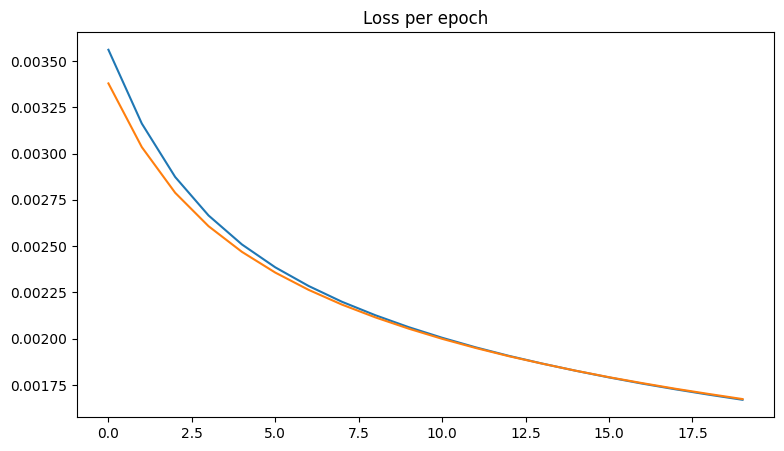

In [49]:
plt.figure(figsize=(9,5))

plt.plot(epoch_train_loss)
plt.plot(epoch_val_loss)

plt.title('Loss per epoch')

In [52]:
encoder_decoder.load_weights("encoder_decoder_epoch_5.weights.h5")

In [53]:
# encoder
encoder_input = encoder_decoder.input[0]
encoder_output = encoder_decoder.get_layer('dense_encoder').output
encoder_model = Model(encoder_input, encoder_output)

# decoder# 
text_input = encoder_decoder.input[1]
enc_output = Input(shape=(256,), name='Enc_Output')
text_output = encoder_decoder.get_layer('LSTM2').output
add1 = tf.keras.layers.Add()([text_output, enc_output])
fc_1 = fc1(add1)
decoder_output = output_layer(fc_1)

decoder_model = Model(inputs = [text_input, enc_output], outputs = decoder_output)

In [54]:
def greedysearch(img):
    image = cheXnet_Features[img]
    input_ = 'startseq'
    image_features = encoder_model.predict(image)
    
    result = []
    for i in range(153):
        input_tok = [tokenizer.word_index[w] for w in input_.split()]
        input_padded = pad_sequences([input_tok], 153, padding='post')
        predictions = decoder_model.predict([input_padded, image_features])
        arg = np.argmax(predictions)
        if arg != 7:   # endseq
            result.append(tokenizer.index_word[arg])
            input_ = input_ + ' ' + tokenizer.index_word[arg]
        else:
            break
    rep = ' '.join(e for e in result)
    return rep

In [55]:
def load_image(img_name):
    image = Image.open(img_name)
    X = np.asarray(image.convert("RGB"))
    X = np.asarray(X)
    X = preprocess_input(X)
    X = resize(X, (224,224,3))
    X = np.expand_dims(X, axis=0)
    X = np.asarray(X)
    return X

In [56]:
def get_result(idx=0):
  
  plt.figure(figsize=(9,5))

  pre_Report = greedysearch(cv_data['Person_id'][idx]) # result after 20 epochs
  print('------------------------------------------------------------------------------------------------------')
  print("Predicted Report : ",pre_Report)
  print('------------------------------------------------------------------------------------------------------')
  print("Actual Report : ",cv_data['Report'][idx])

  plt.subplot(121)
  img = load_image(cv_data['Image1'][idx])
  plt.imshow(img[0])

  plt.subplot(122)
  img = load_image(cv_data['Image2'][idx])
  plt.imshow(img[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


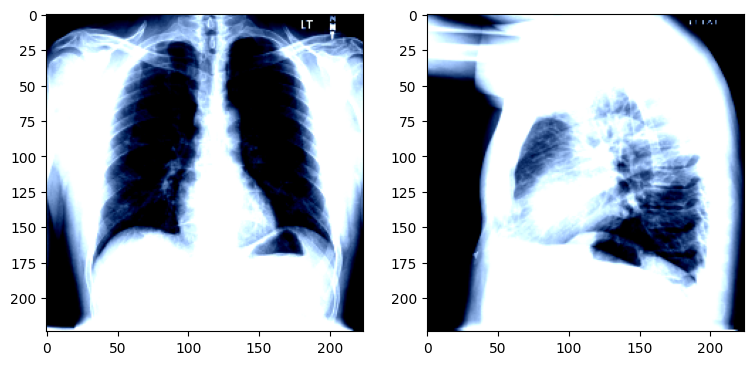

In [57]:
get_result(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
------------------------------------------------------------------------------------------------------
Predicted Report :  the heart normal size . the mediastinum unremarkable . the lungs are clear .
------------------------------------------------------------------------------------------------------
Actual Report :  startseq the cardiomediastinal silhouette and pulmonary v

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.626949].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.46228].


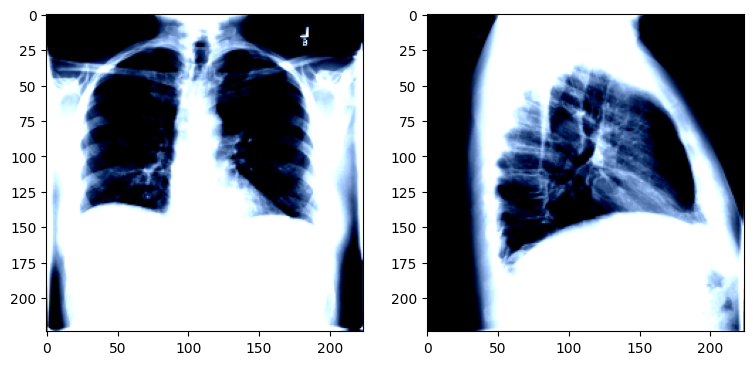

In [58]:
get_result(98)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.09695..2.3606043].


------------------------------------------------------------------------------------------------------
Predicted Report :  the heart size and pulmonary vascularity appear within normal limits . the lungs are free focal airspace disease . no pleural effusion pneumothora seen . no pneumothora .
------------------------------------------------------------------------------------------------------
Actual Report :  startseq the cardiomediastinal silhouette normal size and configuration .  pulmonary vasculature within normal limits .  the lungs are wellaerated .  there no pneumothora pleural effusion focal consolidation .  endseq


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.995931..2.4446132].


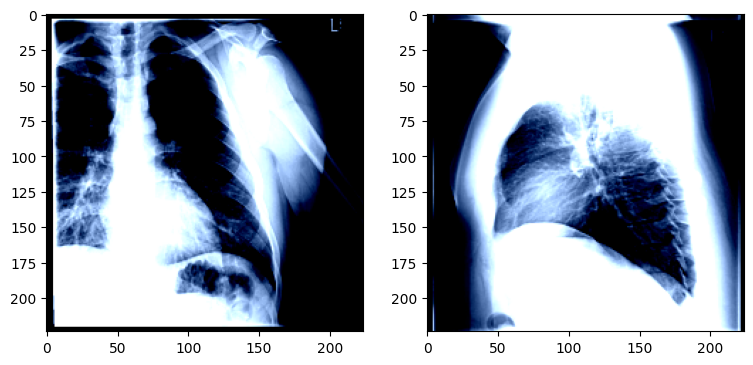

In [59]:
get_result(48)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6240096].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4077675].


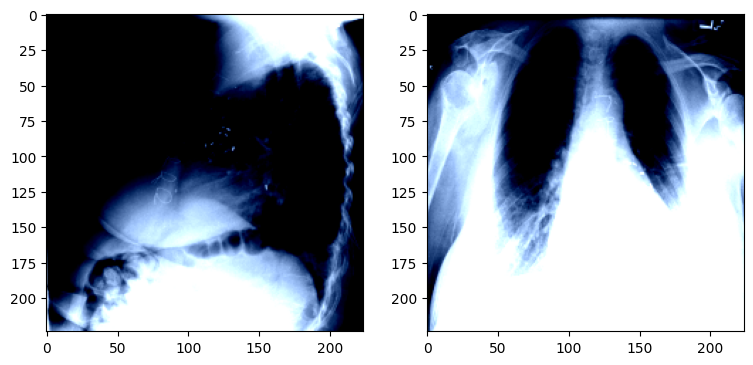

In [65]:
get_result(4)